# Direct unbinned Datasets
Here I want to compute the npred at each event coordinate directly. 
Therefore I will evaluate (integrate) the model on a true geometry and multiply it with the exposure and a cube with probabilities for the PSF and Edisp.

General Problem: The spectral index shifts the weight inside the bins. For a very steep spectrum the bin "center" needs to be more towards the lower bin edge and vice versa. If this is not accounted for the edisp PDF for wrong energies is used, i.e. you get much less flux than the model actually predicts.


Possible Solution: calculate 3 acceptance cubes. One for lower bin edges, one for centers and one for upper bin edges. Compute the center of gravity for the bins dependent on the index (a factor). Interpolate between the acceptance cubes. Or just shift the event energies to the first bin center 

In [3]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from astropy.utils import lazyproperty
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.estimators import LightCurveEstimator
from gammapy.maps import MapAxis, WcsGeom, Map, MapAxes, WcsNDMap
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)
# from utils import EdispInv

0.20.1


## short visualization of bin center vs center of gravity

In [4]:
from scipy.special import erf

def my_center(alpha, norm=False):
    result = np.zeros_like(alpha)
    mask = alpha != -1
    exp=alpha[mask]+1
    base=0.5*(e2**exp + e1**exp)
    result[mask] = np.power(base, 1/exp)
    result[~mask] = np.sqrt(e2*e1)
    if norm:
        result /= np.sqrt(e1*e2)
#         result /= e2-e1  # devide by bin size
#         result += 1
    return result

def erf_norm(func = None):
    result = erf(alphas)+2
    if func:
        result = func(result)
    norm = (e2-e1) / (result[-1]-result[0])
    result *= norm
    shift = 55 - result[50]
    result += shift
    return result

def my_center2(alpha, binsz):
    """
    give the center of gravity energy as fraction of lower bin edge
    alpha: index of the spectrum
    binsz: higher edge / lower edge
    """
    result = np.zeros_like(alpha)
    mask = alpha != -1
    exp=alpha[mask]+1
    result[mask] = np.power(0.5 + 0.5*binsz**exp, 1/exp)
    result[~mask] = np.sqrt(binsz)
    return result

In [9]:
e1 = 10
bpd = 4
binsz = np.power(10,1/bpd)
e2 = e1*binsz
alpha=-0.9999999999999

log_center = np.sqrt(e1*e2)
print(f"Log_center = {log_center:.2f}")

exp=alpha+1
base=0.5*(e2**exp + e1**exp)
my_cent = np.power(base, 1/exp)
print(f"My center = {my_cent:.2f}")

Log_center = 13.34
My center = 13.34


In [10]:
alphas = np.linspace(-5,5,101)
# alphas

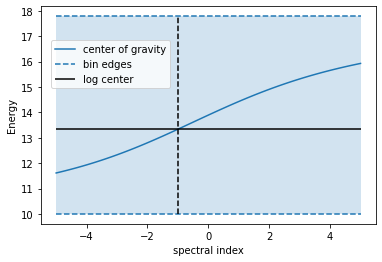

In [11]:
plt.plot(alphas, my_center(alphas), label='center of gravity')
plt.fill_between(alphas,e1,e2, alpha=0.2)
plt.hlines([e1,e2],alphas[0],alphas[-1], ls='dashed', label='bin edges')
plt.hlines(np.sqrt(e1*e2),alphas[0],alphas[-1], color='k', label='log center')
# plt.plot(alphas, erf_norm(lambda x:np.power(x,0.06)))
# plt.plot(alphas, my_center2(alphas, binsz)*e1)
plt.vlines(-1,e1,e2, ls='--', color='k')
plt.xlabel('spectral index')
plt.ylabel('Energy')
plt.legend(bbox_to_anchor=(0.4,0.6))

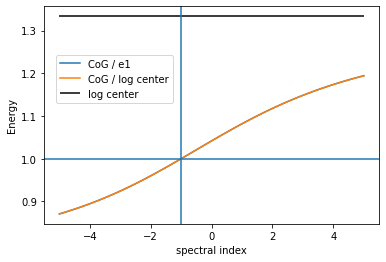

In [12]:
plt.plot(alphas, my_center2(alphas, binsz)/np.sqrt(binsz), label='CoG / e1')
plt.plot(alphas, my_center(alphas, True), label='CoG / log center')
plt.hlines(np.sqrt(binsz),alphas[0],alphas[-1], color='k', label='log center')
plt.xlabel('spectral index')
plt.ylabel('Energy')
plt.axhline(1)
plt.axvline(-1)
plt.legend(bbox_to_anchor=(0.4,0.8))

## continue with unbinned dataset

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [21]:
PSF_CONTAINMENT = 0.999
CUTOUT_MARGIN = 0.1 * u.deg

class EventDataset():
    stat_type = "cash"
    tag = "EventDataset"
    
    def __init__(self, MapDataset, observation, events=None, name='test-eds', tight_exp=True):
        """
        MapDataset: gammapy.datasets.MapDataset for some convinience (true and reco geom need the same shape)
        observation: gammapy.data.Observation with the event data and IRFs
        name: str, a name for the dataset  
        """
        self.ds = MapDataset.copy(name=MapDataset.name)  # TODO: only use the relevant things from the ds to save memory
        self.ds.models = MapDataset.models.copy()
        self.events = events or observation.events
        self.obs = observation
        self.name = name
        self.meta_table=None
        self._evaluators=None
        self._background_cache=None
        self.tight_exp = tight_exp
        
        self._init_mask_safe()
        self._init_acceptance()
        self._init_evaluators()
        
        
    @property
    def models(self):
        # use the dataset's models for now
        return self.ds.models
    
    def _init_evaluators(self):
        """Set UnbinnedEvaluator(s)"""
        self._evaluators = {}

        if self.models is not None:
            models = DatasetModels(self.models)
            models = models.select(datasets_names=self.ds.name)
            
            irfs={'psf':self.obs.psf, 'edisp':self.obs.edisp}
            irfs['exposure'] = self.tight_exposure()
            events = self.events.select_row_subset(self.mask_safe)
            for model in models:
                if not isinstance(model, FoVBackgroundModel):
                    evaluator = UnbinnedEvaluator(
                        model=model,
                        irfs=irfs,
                        events=events,
                        pointing=self.obs.pointing_radec,
                        acceptance = self.acceptance
                    )
                    self._evaluators[model.name] = evaluator

        
    def tight_exposure(self):
        """
        remove energy bins of the exposure map where the acceptance is 0.
        This helps to safe memory/computing time and with an issue where
        events get contributions from bins not punished by the acceptance.
        This can happend if the event energy is lower than the center of the mask_safe
        and might lead to super steep spectra 
        """
        if not self.tight_exp:
            return self.ds.exposure
        
        self._init_acceptance()
        if isinstance(self.acceptance, tuple):
            e_acceptance=self.acceptance[0].data.sum(axis=(1,2))
        else:
            e_acceptance=self.acceptance.data.sum(axis=(1,2))
#         e_acceptance/=e_acceptance.max()
        # look for the index where the first numbers > 0 appear
        idx1=0
        idx2=-1
        while True:
            if e_acceptance[idx1]>0.0:
                break
            else:
                idx1 += 1
        while True:
            if e_acceptance[idx2]>0.0:
                break
            else:
                idx2 -= 1
        if idx2==-1:
            idx2 = None
        else:
            idx2 += 1
            
        if idx1==0 and idx2 is None:
            return self.ds.exposure
        else:        
            if isinstance(self.acceptance, tuple):
                self.acceptance = [acc.slice_by_idx({'energy':slice(idx1,idx2)}) for acc in self.acceptance]
            else:
                self.acceptance = self.acceptance.slice_by_idx({'energy':slice(idx1,idx2)})
            return self.ds.exposure.slice_by_idx({'energy_true':slice(idx1,idx2)})
        
        
    def _init_mask_safe(self):
        """
        create a mask for events which are not part of any evaluator
        and will be discarded in the analysis
        For now use the mask_safe of the datset
        """
        coords = self.events.map_coord(self.ds.mask_safe.geom)
        self.mask_safe = self.ds.mask_safe.get_by_coord(coords)==1
        
    def _init_acceptance(self):
        """
        Build the acceptance cube (dimeansions of true geom)
        Contains the fraction of each pixel that contributes to the sum of npred
        Strategy: Convolve the mask safe with the psf and edisp        
        """
        mask = Map.from_geom(geom=self.ds.mask_safe.geom.as_energy_true,
                            data=self.ds.mask_safe.data.astype(float))
        
        # compute the Kernels
        # for now use Kernels from the Map center, BUT acceptance is especially
        # important for mask_safe edges so use Kernel for larger offset???
        psf_kernel = self.ds.psf.get_psf_kernel(geom=self.ds.exposure.geom)
        if isinstance(self.ds.edisp, gammapy.irf.edisp.map.EDispMap):
            energy_axis = self.ds.mask_safe.geom.axes['energy']
            energy_axis2 = MapAxis.from_nodes(
                energy_axis.edges.value[1:], unit="TeV", name="energy", interp="log"  
            )  # second energy axis with centers at the upper bin edges
            edisp_kernel = self.ds.edisp.get_edisp_kernel(energy_axis)
            edisp_kernel2 = self.ds.edisp.get_edisp_kernel(energy_axis2)
        else:
            edisp_kernel = self.ds.edisp.get_edisp_kernel()
        
        mask_convolved=mask.convolve(psf_kernel)
        mask_convolved1=mask_convolved.apply_edisp(edisp_kernel)
        mask_convolved2=mask_convolved.apply_edisp(edisp_kernel2)
        self.acceptance = mask_convolved1 , mask_convolved2
        
    def response_background(self):
        """
        compute the response of the background.
        returns: interpolated bkg value for all events, sum of bkg counts
        """
        
        if self._background_cache is not None and not self.ds._background_parameters_changed:
            return self._background_cache
        
        # get the background map, use the MapDataset caching
        background = self.ds.background
        if self.ds.background_model and background:
            if self.ds._background_parameters_changed:
                values = self.ds.background_model.evaluate_geom(geom=background.geom)
                if self.ds._background_cached is None:
                    self.ds._background_cached = background * values
                else:
                    self.ds._background_cached.quantity = (
                        background.quantity * values.value
                    )
            bkg_map = self.ds._background_cached
        else:
            bkg_map = background
       
        # interpolate and sum the bkg values
        events = self.events.select_row_subset(self.mask_safe)
        coords = events.map_coord(background.geom)
        bkg_sum = bkg_map.data[self.ds.mask_safe.data].sum()
        self._background_cache = bkg_map.interp_by_coord(coords, method='linear'), bkg_sum
        return self._background_cache
    
    def stat_sum(self, response_only=False):
        """
        compute the unbinned TS value
        """
        response, npred_sum = self.response_background() # start with the bkg (all events)
        # add the models
        for ev in self._evaluators.values():
            npred, mask, s = ev.compute_response()
            response[mask] += npred
            npred_sum += s
        
        if response_only:
            return np.log(response)
        if np.all(response>0): 
            # valid response - no event has npred <= 0
            logL = np.sum(np.log(response)) - npred_sum
            return -2 * logL
        else:
            # invalid response, reject the model
            return np.inf

class UnbinnedEvaluator():
    def __init__(self, model, irfs, events, pointing, acceptance, max_radius=None):
        """
        model: SkyModel
        irfs: dict with "psf"--> PSF3D; "exposure"-->WcsNDMap with exosure data; "edisp"-->
        """
        self.model = model
        self.irfs = irfs
        self.events=events
        self.max_radius=max_radius
        self.pointing=pointing
        self.acceptance = [acceptance[i].cutout(position=self.model.position,
                width=self.cutout_width, odd_npix=True).data for i in [0,1]]
        self.irf_cube=None
        self._cached_parameter_values = None
        self._cached_parameter_values_previous = None
        self._cache = None
        self.acc_idx = 0
        
    @property
    def psf_width(self, containment=PSF_CONTAINMENT):
        """Width of the PSF"""
        if "psf" in self.irfs.keys():
            #TODO: apply energy mask, so only use valid energies, not the whole range
            energy_axis = self.irfs['exposure'].geom.axes["energy_true"]
            offset = self.pointing.separation(self.model.position)

            radii = self.irfs["psf"].containment_radius(
                fraction=containment, offset=offset, energy_true=energy_axis.center
            )
            max_radius = np.max(radii)
        else:
            psf_width = 0 * u.deg
        return max_radius*2
    
    @property
    def cutout_width(self):
        """Cutout width for the model component"""
        return self.psf_width + 2 * (self.model.evaluation_radius + CUTOUT_MARGIN)
        
    def build_exposure(self):
        self.exposure = self.irfs['exposure'].cutout(
                    position=self.model.position, width=self.cutout_width, odd_npix=True
                )
        
    def init_mask(self):
        """
        Mask events far away from the model. This is an additional mask to the i.e. energy mask on events
        """
        geom_image=self.exposure.geom.to_image()
        coords = self.events.map_coord(geom_image)
        self.mask = geom_image.contains(coords)
    
    def build_psf(self):
        geom=self.exposure.geom
        psf3d=self.irfs['psf']
        psf3d.normalize()
        energy_axis_true = geom.axes["energy_true"]
        rad=geom.separation(self.events.radec[self.mask,None,None,None])
#         offsets=geom.separation(self.pointing)
        offsets = self.pointing.separation(self.model.position)
        psf_factors=psf3d.evaluate(energy_true=energy_axis_true.center[None,:,None,None], 
                                             rad=rad, offset=offsets)
        psf_factors /= psf_factors.sum(axis=(2,3), keepdims=True) # normalize
        return np.nan_to_num(psf_factors)
    
#         # point psf
#         coords = self.events.map_coord(geom.to_image()).apply_mask(self.mask)
#         idx_lon, idx_lat = geom.to_image().coord_to_idx(coords)
#         psf_factors = np.zeros(tuple([test.mask.sum()])+test.exposure.geom.data_shape)
#         for e,(i,j) in enumerate(zip(idx_lon,idx_lat)):
#             psf_factors[e,:,i,j]=1
#         return psf_factors
        
    def build_edisp(self):
        # maybe instead of EdispInv class, evaluate EnergyDispersion2D and renormalize similar to build_psf?
        event_e = self.events.energy[self.mask]
        offsets = self.events.radec[self.mask].separation(self.pointing) # maybe this needs to be one offset for each pixel
        energy_true = self.exposure.geom.axes['energy_true']
        # based on inverse Edisp
#         edisp = EdispInv(self.irfs['edisp'], event_e.min(), event_e.max())
#         edisp_factors = edisp.evaluate(offset = offsets[:,None], energy=event_e[:,None], energy_true=energy_true.center[None,:])

        edisp2d=self.irfs['edisp']
        edisp_factors=np.zeros((len(event_e),len(energy_true.center)))
        for i,(offset,e) in enumerate(zip(offsets,event_e)):
            kernel=edisp2d.to_edisp_kernel(offset=0.1*u.deg, energy_true=energy_true.edges)
            edisp_factors[i]=kernel.evaluate(energy=e).flatten()
        return edisp_factors
    
#         # diagonla edisp
#         factors = np.zeros((len(event_e),len(energy_true.center)))
#         for i,e in enumerate(event_e):
#             dist = np.abs(energy_true - e)
#             factors[i,dist.argmin()] = 1
#         return factors

    @lazyproperty
    def _energy_binsz(self):
        """
        fraction of the high bin edges / low bin edges
        """
        ebins = self.exposure.geom.axes['energy_true'].edges.value
        fractions = ebins[1:] / ebins[:-1]
        return np.mean(fractions)
    
    @property
    def _energy_shift(self):
        """
        give the fraction of model increase based on the shift of 
        the center of gravity compared to the log bin center.
        
        """
        # get the index of the model
        alpha = - self.model.parameters.value[self._index_idx]
        if alpha == -1:
            # center of gravity is equal to log bin center
            return 1
        # compute center of gravity for bins        
        exp=alpha+1.0
        result = np.power(0.5 + 0.5*self._energy_binsz**exp, 1/exp)
        result /= np.sqrt(binsz)  # as fraction of the log bin center
        return result**alpha

    @lazyproperty
    def _index_idx(self):
        """norm index"""
        names = self.model.parameters.names
        ind = [idx for idx, name in enumerate(names) if name in ["index", "alpha"]]
        if len(ind) == 1:
            return ind[0]
        else:
            return None

    @property
    def parameters_changed(self):
        """Parameters changed"""
        values = self.model.parameters.value

        # TODO: possibly allow for a tolerance here?
        changed = ~np.all(self._cached_parameter_values == values)

        if changed:
            self._cached_parameter_values = values

        return changed
    
    @property
    def parameter_norm_only_changed(self):
        """Only norm parameter changed"""
        norm_only_changed = False
        idx = self._norm_idx
        values = self.model.parameters.value
        if idx and self._computation_cache is not None:
            changed = self._cached_parameter_values_previous == values
            norm_only_changed = sum(changed) == 1 and changed[idx]

        if not norm_only_changed:
            self._cached_parameter_values_previous = values
        return norm_only_changed
    
    @lazyproperty
    def _norm_idx(self):
        """norm index"""
        names = self.model.parameters.names
        ind = [idx for idx, name in enumerate(names) if name in ["norm", "amplitude"]]
        if len(ind) == 1:
            return ind[0]
        else:
            return None
        
    def renorm(self):
        value = self.model.parameters.value[self._norm_idx]
        value_cached = self._cached_parameter_values_previous[self._norm_idx]
        return value / value_cached
    
    def init_irf_cube(self):
        """
        compute the static cube representing the IRFs
        with dimensions (Nevents, energy, lon, lat)
        For each event and model pixel: IRF corrected exposure that contributes 
        to that event
        """
        self.build_exposure()
        self.init_mask()
        psf = self.build_psf()
        edisp = self.build_edisp()
        self.irf_cube = self.exposure.quantity* psf * edisp[:,:,None,None]
    
    @lazyproperty
    def _compute_response(self):
        
        if not self.parameter_norm_only_changed or self._cache is None:       
            if self.irf_cube is None:
                self.init_irf_cube()
            npred=self.model.integrate_geom(self.exposure.geom)
            response = np.multiply(npred, self.irf_cube).sum(axis=(1,2,3))
            npred_sum = npred * self.exposure.quantity * self.acceptance[self.acc_idx]
            npred_sum = npred_sum.quantity.to_value('').sum()
#             npred_sum *= self._energy_shift
            self._cache = response.to_value(''), self.mask, npred_sum  
        else:
            self._cache[0] *= self.renorm()
            self._cache[2] *= self.renorm()
        return self._cache
    
    def compute_response(self):
        """
        compute the npred values at the event coordinates 
        and the sum of counts from the model
        
        Returns
        -------
        response: `np.array` (shape n)
            npred values at the event coordinates (only contribution events)
        mask: `np.array` (shape N with n true entries)
            the mask to map the response to the total reponse
        npred_sum: `float`
            summed npred of the model
        """
        if self.parameters_changed or self._cache is None:
            del self._compute_response

        return self._compute_response

In [16]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.logspace(-1,2,49)
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)
geom_true = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis_true],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [17]:
%%time
maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg', bias_percent=8)
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  #, migra_axis=migra_axis

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)
# assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
# dataset.background.data[~dataset.mask_safe.data] = 0.0

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model
# dataset.background_model.spectral_model.tilt.frozen = False
# dataset = maker_fov.run(dataset)
# print(
#     f"Background norm obs {obs1.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} \
#     (tilt={dataset.background_model.spectral_model.tilt.value:.2f})"
# )

CPU times: user 4.66 s, sys: 840 ms, total: 5.5 s
Wall time: 5.54 s


In [18]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab

model_gauss.spatial_model.parameters.freeze_all()
model_gauss.spectral_model.amplitude.min = 0.
model_gauss.spectral_model.alpha.min = 0.
model_gauss.spectral_model.beta.min = 0.

# model_gauss.spectral_model.amplitude.max = 3.5e-11
# model_gauss.spectral_model.alpha.max = 5
# model_gauss.spectral_model.beta.max = 4
# model_gauss.apply_irf['psf']=False
# model_gauss.apply_irf['edisp']=False
model_gauss.parameters.to_table()

model_ref = model_gauss.copy()

## test the unbinned evaluator

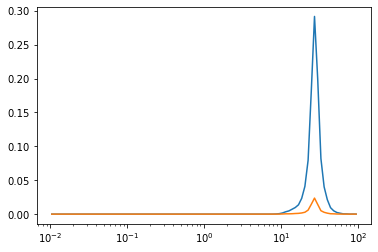

In [19]:
### different energy bin sizes only result in different normalizations of the edisp kernel
ek=obs1.edisp.to_edisp_kernel(offset=0.1*u.deg)
ek2=obs1.edisp.to_edisp_kernel(offset=0.1*u.deg, energy=[26.9,27.1]*u.TeV)

plt.semilogx(ek.axes['energy_true'].center, ek.evaluate(energy=27*u.TeV))
plt.semilogx(ek.axes['energy_true'].center, ek2.evaluate(energy=27*u.TeV))

In [30]:
events_test = obs1.events.select_energy([10,100]*u.TeV)
eds = EventDataset(dataset, obs1)
irfs={'psf':obs1.psf, 'edisp':obs1.edisp, 'exposure':eds.tight_exposure()}
print(len(events_test.table))
test= UnbinnedEvaluator(model=model_gauss, irfs=irfs, events=events_test, pointing=obs1.pointing_radec, acceptance=eds.acceptance)

673


In [31]:
%%time
test.init_irf_cube()

CPU times: user 2.89 s, sys: 936 ms, total: 3.83 s
Wall time: 3.82 s


In [32]:
%%time
response, mask, s = test.compute_response()

CPU times: user 422 ms, sys: 15.6 ms, total: 438 ms
Wall time: 436 ms


In [33]:
s

15.50206080019419

In [34]:
response

array([3.65434598e-08, 5.70601466e-05, 1.02045206e-06, 5.75402719e-09,
       0.00000000e+00, 1.37935235e-06, 2.82134524e-07, 1.46673177e-04,
       3.15092654e-06, 0.00000000e+00, 3.95231077e-06, 1.15303460e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.16075366e-05, 0.00000000e+00, 6.22146023e-07, 0.00000000e+00])

In [35]:
# compare with npred cube
dataset.models += model_gauss
dataset.npred()
npred_crab = dataset.evaluators['crab_model_gauss'].compute_npred()

In [36]:
coords = test.events.map_coord(npred_crab.geom).apply_mask(mask)
response1 = npred_crab.interp_by_coord(coords, method='linear')

In [37]:
response1

array([ 4.61617246e-08,  8.47772974e-05,  1.29521864e-06,  1.04885461e-07,
        2.65482455e-07,  1.78145040e-06,  1.00287201e-06,  1.79231082e-04,
        3.36106876e-06,  6.87426944e-07,  5.19790957e-06,  1.32281407e-06,
        2.58445524e-11, -4.20683312e-12, -7.68559078e-14,  5.49228717e-13,
        8.78384926e-05,  3.77691331e-10,  8.57960762e-07,  1.07250234e-07])

[]

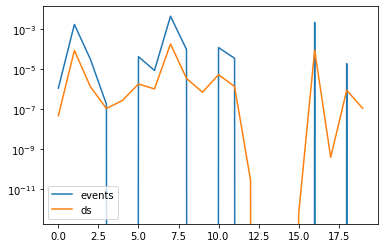

In [38]:
plt.plot(response*30, label='events')
plt.plot(response1, label='ds')
plt.legend()
plt.semilogy()

In [39]:
eval_crab=dataset.evaluators['crab_model_gauss']

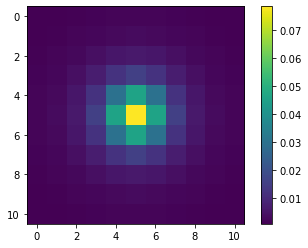

In [40]:
plt.imshow(eval_crab.psf.psf_kernel_map.data[40,28:39,28:39])
plt.colorbar()

In [41]:
psf_unb = test.build_psf()

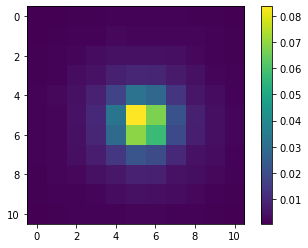

In [43]:
plt.imshow(psf_unb[2,33,51:62,38:49])
plt.colorbar()

## test the unbinned dataset

In [30]:
dataset.models += model_gauss

In [47]:
print(dataset)

MapDataset
----------

  Name                            : OTlLldoP 

  Total counts                    : 1238 
  Total background counts         : 1192.13
  Total excess counts             : 45.87

  Predicted counts                : 1206.91
  Predicted background counts     : 1192.13
  Predicted excess counts         : 14.78

  Exposure min                    : 8.30e+05 m2 s
  Exposure max                    : 1.11e+09 m2 s

  Number of total bins            : 1470000 
  Number of fit bins              : 564317 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15647.64

  Number of models                : 2 
  Number of parameters            : 12
  Number of free parameters       : 4

  Component 0: FoVBackgroundModel
  
    Name                      : OTlLldoP-bkg
    Datasets names            : ['OTlLldoP']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.000   +/-    0.00            

In [48]:
params=dataset.models.parameters.free_parameters.names # ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
x_values = np.arange(len(params))
if 'par_input' not in locals():
    par_input=[dataset.models.parameters[par].value for par in params]
    
for i,par in enumerate(params):
    dataset.models.parameters.free_parameters[par].value = par_input[i]
sampler = MapDatasetEventSampler(random_state=69)
events = sampler.run(dataset, obs1)

print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")
      
counts = Map.from_geom(geom)

counts.fill_events(events)
dataset.counts=counts
      
counts.data.sum()

Source events: 19
Background events: 3709


3728.0

In [49]:
eds = EventDataset(dataset, obs1)

In [50]:
%%time
eds.stat_sum()

CPU times: user 1min 28s, sys: 51.5 s, total: 2min 19s
Wall time: 2min 19s


15689.95951220089

## test some fitting

In [35]:
%%time
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run([dataset])
print(result)
result.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 202
	total stat : 15412.24

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 11 s, sys: 23.4 ms, total: 11 s
Wall time: 11 s


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,9.1340e-01,,2.834e-02,nan,nan,False,True,
spectral,amplitude,3.1742e-11,cm-2 s-1 TeV-1,6.274e-12,0.000e+00,nan,False,True,
spectral,alpha,1.6276e+00,,3.991e-01,0.000e+00,nan,False,False,
spectral,beta,4.2859e-01,,1.775e-01,0.000e+00,nan,False,False,


In [36]:
%%time  
result2 = fit.run([eds])
print(result2)
result2.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 187
	total stat : 15520.88

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 3min 5s, sys: 2min 1s, total: 5min 7s
Wall time: 5min 7s


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,9.3136e-01,,2.855e-02,nan,nan,False,True,
spectral,amplitude,2.4751e-11,cm-2 s-1 TeV-1,5.838e-12,0.000e+00,nan,False,True,
spectral,alpha,1.5219e+00,,5.029e-01,0.000e+00,nan,False,False,
spectral,beta,4.5939e-01,,2.193e-01,0.000e+00,nan,False,False,


## test the significance

In [31]:
# dataset.models += model_gauss

pointing = obs1.pointing_radec
params=dataset.models.parameters.free_parameters.names # ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
x_values = np.arange(len(params))
if 'par_input' not in locals():
    par_input=[dataset.models.parameters[par].value for par in params]

In [ ]:
%%time
### Compare analysis for n MC simulations
### This takes very long for now
n=100


par_binned=[]
err_binned=[]
par_unbin =[]
err_unbin =[]
dTS_binned = []
dTS_unbinned = []

for ii in range(n): #range(n): #[21, 62, 71, 74]:
    ### draw random revents
    for i,par in enumerate(params):
        dataset.models.parameters.free_parameters[par].value = par_input[i]
    sampler = MapDatasetEventSampler(random_state=ii)
    events = sampler.run(dataset, obs1)
    
    ### set up binned and unbinned datasets
    counts = Map.from_geom(geom)
    counts.fill_events(events)
    dataset.counts=counts
    
    eds = EventDataset(dataset, obs1, events=events)
    
    ### fit both datasets
    fit = Fit(optimize_opts={"print_level": 0})
    result = fit.run([dataset])
    result2 = fit.run([eds])
        
    ### parameter comparison
    par_binned.append([result.parameters[par].value for par in params])
    err_binned.append([result.parameters[par].error for par in params])

    par_unbin.append([result2.parameters[par].value for par in params])
    err_unbin.append([result2.parameters[par].error for par in params])
    
    ### test of the source significance
    ts_binned = result.total_stat
    ts_unb = result2.total_stat
    print(f"{ii}: TS_binned = {ts_binned:.2f}; TS_unbinned = {ts_unb:.2f}")
    with dataset.models.parameters.restore_status():
        dataset.models.parameters['amplitude'].value = 0
        dataset.models.parameters['amplitude'].frozen = True
        res=fit.optimize(dataset)
        ts_binned0 = res.total_stat
    with eds.models.parameters.restore_status():
        eds.models.parameters['amplitude'].value = 0
        eds.models.parameters['amplitude'].frozen = True
        res2=fit.optimize([eds])
        ts_unb0 = res2.total_stat
    dTS_binned.append(ts_binned0-ts_binned)
    dTS_unbinned.append(ts_unb0-ts_unb)

0: TS_binned = 16058.69; TS_unbinned = 16050.66
1: TS_binned = 15141.16; TS_unbinned = 15148.81
2: TS_binned = 14946.38; TS_unbinned = 14941.60
3: TS_binned = 15171.49; TS_unbinned = 15163.17
4: TS_binned = 15243.07; TS_unbinned = 5583.02
5: TS_binned = 16139.17; TS_unbinned = 16140.44


/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/m

6: TS_binned = 15196.60; TS_unbinned = 15204.57
7: TS_binned = 15117.52; TS_unbinned = 15117.84
8: TS_binned = 15824.38; TS_unbinned = 15825.83
9: TS_binned = 15425.63; TS_unbinned = 15426.12
10: TS_binned = 15368.59; TS_unbinned = 15359.56
11: TS_binned = 15658.82; TS_unbinned = 15653.12
12: TS_binned = 15762.58; TS_unbinned = 15761.32
13: TS_binned = 15214.53; TS_unbinned = 6736.10
14: TS_binned = 14469.78; TS_unbinned = 14483.60
15: TS_binned = 15723.56; TS_unbinned = 15725.83
16: TS_binned = 15333.66; TS_unbinned = 15337.53
17: TS_binned = 15326.99; TS_unbinned = 15321.34
18: TS_binned = 15763.10; TS_unbinned = 15758.21
19: TS_binned = 14845.75; TS_unbinned = 14846.06
20: TS_binned = 15422.79; TS_unbinned = 15428.10
21: TS_binned = 15497.94; TS_unbinned = 15500.84


/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


22: TS_binned = 15424.00; TS_unbinned = 8687.65
23: TS_binned = 15470.36; TS_unbinned = 15467.38
24: TS_binned = 15523.11; TS_unbinned = 15523.67
25: TS_binned = 14917.79; TS_unbinned = 14931.57
26: TS_binned = 15468.92; TS_unbinned = 15466.80
27: TS_binned = 15625.82; TS_unbinned = 15621.55
28: TS_binned = 15759.71; TS_unbinned = 15758.30
29: TS_binned = 15570.79; TS_unbinned = 15575.47
30: TS_binned = 14967.03; TS_unbinned = 14968.12
31: TS_binned = 15328.56; TS_unbinned = 5930.07
32: TS_binned = 14792.52; TS_unbinned = 14804.98
33: TS_binned = 15397.20; TS_unbinned = 15399.22
34: TS_binned = 16109.13; TS_unbinned = 16108.26
35: TS_binned = 14622.22; TS_unbinned = 4729.05
36: TS_binned = 15157.13; TS_unbinned = 15155.94
37: TS_binned = 16392.35; TS_unbinned = 8514.95
38: TS_binned = 15306.57; TS_unbinned = 8145.28
39: TS_binned = 15376.12; TS_unbinned = 15377.80
40: TS_binned = 14573.86; TS_unbinned = 14577.50
41: TS_binned = 15491.51; TS_unbinned = 4100.29
42: TS_binned = 15350.45; 

/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


48: TS_binned = 15313.44; TS_unbinned = 5483.16
49: TS_binned = 15553.96; TS_unbinned = 15547.49
50: TS_binned = 15070.95; TS_unbinned = 14621.34
51: TS_binned = 15327.10; TS_unbinned = 15323.10
52: TS_binned = 15051.08; TS_unbinned = 15052.32
53: TS_binned = 15501.79; TS_unbinned = 15502.90
54: TS_binned = 16049.08; TS_unbinned = 16040.18


/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/m

/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/m

55: TS_binned = 15540.74; TS_unbinned = 6183.15
56: TS_binned = 15311.82; TS_unbinned = 6226.39
57: TS_binned = 15101.54; TS_unbinned = 7626.43
58: TS_binned = 14977.78; TS_unbinned = 14985.13


/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


59: TS_binned = 15283.64; TS_unbinned = 6456.09
60: TS_binned = 15823.14; TS_unbinned = 15815.98
61: TS_binned = 15921.39; TS_unbinned = 8593.81
62: TS_binned = 15828.61; TS_unbinned = 15831.58
63: TS_binned = 15156.43; TS_unbinned = 15156.60
64: TS_binned = 15606.54; TS_unbinned = 15601.07
65: TS_binned = 16076.86; TS_unbinned = 7697.88
66: TS_binned = 15082.98; TS_unbinned = 15085.53
67: TS_binned = 15203.15; TS_unbinned = 15194.87
68: TS_binned = 15298.83; TS_unbinned = 15293.31


/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/woody/caph/m

69: TS_binned = 15661.46; TS_unbinned = 5730.50
70: TS_binned = 15363.58; TS_unbinned = 15368.31
71: TS_binned = 15002.14; TS_unbinned = 15003.53


In [66]:
par_bin_mean = np.mean(par_binned, axis=0)
par_ubin_mean = np.mean(par_unbin, axis=0)

err_bin_mean = np.mean(err_binned, axis=0)
err_ubin_mean = np.mean(err_unbin, axis=0)

dTS_binned_mean = np.mean(dTS_binned)
dTS_unbinned_mean = np.mean(dTS_unbinned)
print(f"Avg over {n} simulations: \n" +
        f"deltaTS binned   = {dTS_binned_mean:.3f} \n" +
        f"deltaTS unbinned = {dTS_unbinned_mean:.3f}")

par_binned=np.array(par_binned)
par_unbin=np.array(par_unbin)
err_binned=np.array(err_binned)
err_unbin=np.array(err_unbin)
dTS_binned=np.array(dTS_binned)
dTS_unbinned=np.array(dTS_unbinned)

Avg over 100 simulations: 
deltaTS binned   = 13.706 
deltaTS unbinned = 2308.018


In [68]:
np.where(dTS_unbinned>1e2)

(array([ 4, 13, 22, 31, 35, 37, 38, 41, 42, 45, 48, 50, 55, 56, 57, 59, 61,
        65, 69, 72, 82, 84, 89, 91, 92, 95, 98, 99]),)

## investigate a single realiztion where something went wrong

In [51]:
ii = 41
### draw random revents
for i,par in enumerate(params):
    dataset.models.parameters.free_parameters[par].value = par_input[i]
sampler = MapDatasetEventSampler(random_state=ii)
events = sampler.run(dataset, obs1)

### set up binned and unbinned datasets
counts = Map.from_geom(geom)
counts.fill_events(events)
dataset.counts=counts

eds = EventDataset(dataset, obs1, events=events, tight_exp = False)

In [52]:
eds.stat_sum() # 15502.80

15502.751717026666

In [53]:
eds.models.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,False,True,
spectral,amplitude,3.5000e-12,cm-2 s-1 TeV-1,0.000e+00,0.000e+00,nan,False,True,
spectral,alpha,1.8000e+00,,0.000e+00,0.000e+00,nan,False,False,
spectral,beta,4.0000e-01,,0.000e+00,0.000e+00,nan,False,False,


In [54]:
par_manual = np.array([8.16610563e-01, 3.13334428e-29, 7.70978423e+01, 1.52374792e-06])
for i,par in enumerate(params):
    eds.models.parameters.free_parameters[par].value = par_manual[i]

In [55]:
ev=eds._evaluators['crab_model_gauss']

In [56]:
resp, m, s1 = ev.compute_response()

In [57]:
ev.acc_idx = 1
del ev._compute_response

resp, m, s2 = ev.compute_response()

In [58]:
s2/s1, ev._energy_shift

(3.792211248505768, 2149078001.0857697)

In [59]:
energy_axis = eds.ds.mask_safe.geom.axes['energy']
energy_axis2 = MapAxis.from_nodes(
    energy_axis.edges.value[:-1], unit="TeV", name="energy", interp="log"  
)  # second energy axis with centers at the lower bin edges
edisp_kernel = eds.ds.edisp.get_edisp_kernel(energy_axis)
edisp_kernel2 = eds.ds.edisp.get_edisp_kernel(energy_axis2)

In [60]:
edisp_kernel2.pdf_matrix.sum(axis=1)

array([0.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99926224, 0.99782686,
       0.99328355, 0.96129394, 0.86154953])

/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


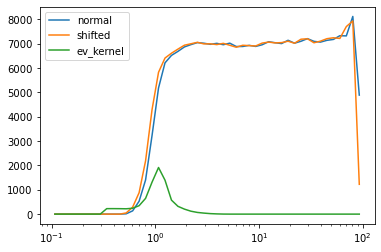

In [61]:
plt.semilogx(edisp_kernel.axes['energy_true'].center, ev.acceptance[0].sum(axis=(1,2)), label='normal')
plt.semilogx(edisp_kernel.axes['energy_true'].center, ev.acceptance[1].sum(axis=(1,2)), label='shifted')
ev_kernel=(ev.irf_cube[321]/ev.exposure.quantity).sum(axis=(1,2))
plt.semilogx(edisp_kernel.axes['energy_true'].center, np.nan_to_num(ev_kernel)*1e4, label='ev_kernel')
plt.legend()

/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.20/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(0.2, 0.8)

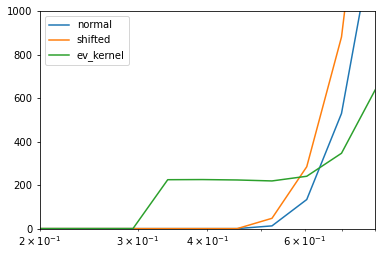

In [62]:
plt.semilogx(edisp_kernel.axes['energy_true'].center, ev.acceptance[0].sum(axis=(1,2)), label='normal')
plt.semilogx(edisp_kernel.axes['energy_true'].center, ev.acceptance[1].sum(axis=(1,2)), label='shifted')
ev_kernel=(ev.irf_cube[321]/ev.exposure.quantity).sum(axis=(1,2))
plt.semilogx(edisp_kernel.axes['energy_true'].center, np.nan_to_num(ev_kernel)*1e4, label='ev_kernel')
plt.legend()
plt.ylim(0,1000)
plt.xlim(0.2,0.8)

In [63]:
ev.acceptance[1].sum(axis=(1,2))

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   47.36535337,
        284.56631513,  881.30142596, 2192.22523282, 4297.81370047,
       5829.86209645, 6415.6648338 , 6614.41666649, 6782.61862524,
       6943.58793144, 7001.89990089, 7061.64575538, 6996.57905631,
       6999.67878895, 6967.91461506, 7020.2140635 , 6940.39887993,
       6860.30952571, 6940.61805358, 6925.41245624, 6912.16189301,
       7029.8070573 , 7071.16188102, 7037.69901313, 7049.74537233,
       7107.45027028, 7025.03321737, 7189.78248081, 7207.39087632,
       7043.17956616, 7109.69872402, 7210.79649108, 7248.9767315 ,
       7220.62006011, 7709.24706905, 7939.13358913, 1224.47459726])

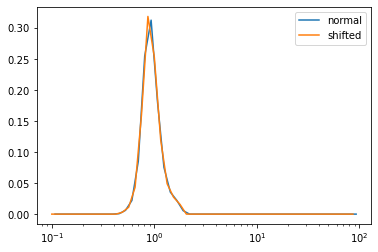

In [64]:
plt.semilogx(edisp_kernel.axes['energy'].center, edisp_kernel.pdf_matrix[15,:], label='normal')
plt.semilogx(edisp_kernel2.axes['energy'].center, edisp_kernel2.pdf_matrix[15,:], label='shifted')
plt.legend()

In [65]:
# get the index of the model
alpha = -test.model.parameters.value[test._index_idx]
if alpha == -1:
    # center of gravity is equal to log bin center
    result2= 1
# compute center of gravity for bins        
exp=alpha+1
result = np.power(0.5 + 0.5*test._energy_binsz**exp, 1/exp)
result /= np.sqrt(binsz)  # as fraction of the log bin center
result2 = result**alpha

In [66]:
result, 1/np.sqrt(test._energy_binsz)

(0.8041758911655564, 0.930572040929699)

In [67]:
alpha+1

-0.8

In [68]:
alpha

-1.8

In [69]:
result2

1.4803626248016701

In [70]:
test._energy_shift

1.4803626248016701

In [89]:
### fit both datasets
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run([dataset])
result2 = fit.run([eds])

In [90]:
result.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,1.0044e+00,,2.922e-02,nan,nan,False,True,
spectral,amplitude,9.3754e-12,cm-2 s-1 TeV-1,4.142e-12,0.000e+00,nan,False,True,
spectral,alpha,3.8295e+00,,1.640e+00,0.000e+00,nan,False,False,
spectral,beta,3.0241e-01,,1.515e+00,0.000e+00,nan,False,False,


In [91]:
result2.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,5.3615e-01,,1.850e-02,nan,nan,False,True,
spectral,amplitude,1.1324e-22,cm-2 s-1 TeV-1,4.041e-23,0.000e+00,nan,False,True,
spectral,alpha,5.1174e+01,,2.749e-01,0.000e+00,nan,False,False,
spectral,beta,9.9790e-01,,5.708e-02,0.000e+00,nan,False,False,


In [102]:
%%time
stat_alpha = fit.stat_profile([eds], eds.models.parameters['alpha'], reoptimize = True)

CPU times: user 3min 13s, sys: 2min 18s, total: 5min 31s
Wall time: 5min 31s


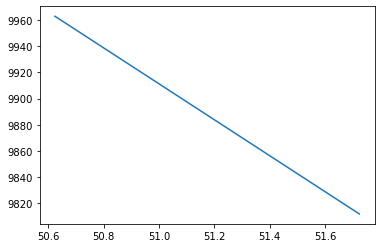

In [104]:
plt.plot(stat_alpha['alpha_scan'], stat_alpha['stat_scan'])

In [92]:
result2.total_stat

10358.194927542325

In [23]:
ev = eds._evaluators['crab_model_gauss']

In [24]:
resp, m, s = ev.compute_response()

In [25]:
resp.argmax()

321

In [26]:
resp[321]

0.01844985630165569

In [27]:
events_safe = eds.events.select_row_subset(eds.mask_safe)

In [28]:
events_safe.energy[m][321]

<Quantity 1.03432512 TeV>

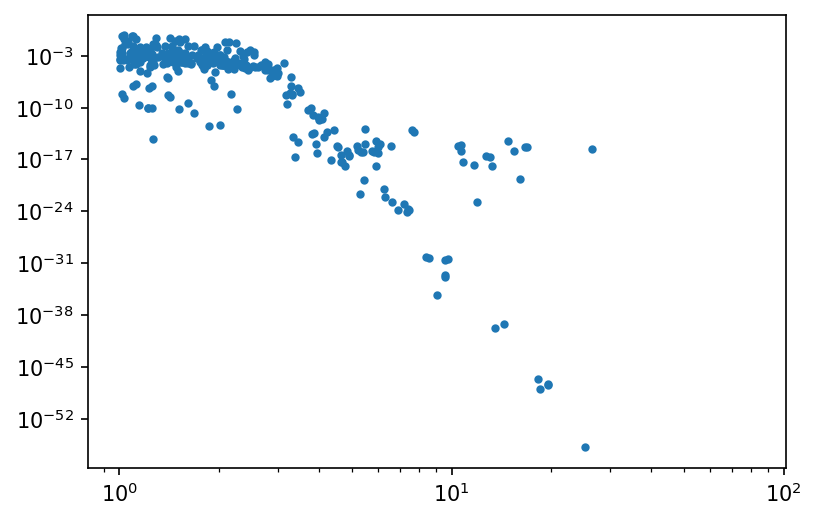

In [190]:
plt.figure(dpi=150)
plt.loglog(events_safe.energy[m],resp, '.')
# plt.ylim(1e-3,1e2)
# plt.xlim(0.9,2)

In [29]:
s

15.501018671416094

In [30]:
npred=ev.model.integrate_geom(ev.exposure.geom)

In [31]:
npred.data.sum(axis=(1,2))#*eds.acceptance.data[:,100,100]

array([6.80490081e-13, 6.37452370e-13, 5.87337905e-13, 5.32283086e-13,
       4.74473157e-13, 4.16001573e-13, 3.58750603e-13, 3.04301887e-13,
       2.53881460e-13, 2.08339521e-13, 1.68161536e-13, 1.33504529e-13,
       1.04250861e-13, 8.00714373e-14, 6.04908812e-14, 4.49486350e-14,
       3.28516668e-14, 2.36163410e-14, 1.66986786e-14, 1.16135740e-14,
       7.94445223e-15, 5.34535191e-15, 3.53755268e-15, 2.30273411e-15,
       1.47434434e-15, 9.28470930e-16, 5.75111346e-16, 3.50388461e-16,
       2.09972239e-16, 1.23762246e-16, 7.17511218e-17, 4.09150804e-17,
       2.29483948e-17, 1.26600494e-17, 6.86961913e-18, 3.66643578e-18])

In [32]:
eds.acceptance.data.sum(axis=(1,2))/17499#[:,100,100]

array([0.01898401, 0.07519442, 0.19950012, 0.4593622 , 0.73646951,
       0.88344274, 0.92726159, 0.95109036, 0.97757456, 0.99147037,
       1.00367503, 1.00030489, 0.99407912, 0.9998076 , 0.99174992,
       1.00072366, 0.98097052, 0.98094091, 0.98744411, 0.98069486,
       0.98945154, 1.00650408, 1.00003287, 0.99439592, 1.01303964,
       0.99569455, 1.00671248, 1.02196685, 1.00574778, 1.00084008,
       1.01087193, 1.01588588, 1.03757791, 1.03870412, 1.16893699,
       0.72275977])

In [33]:
(ev.irf_cube[321]/ev.exposure.quantity).sum(axis=(1,2))

<Quantity [2.40730278e-02, 3.46521964e-02, 6.47004712e-02, 1.31455797e-01,
           1.91610381e-01, 1.39443842e-01, 5.74418914e-02, 3.19875305e-02,
           2.05197976e-02, 1.19957466e-02, 6.92608872e-03, 4.17288933e-03,
           2.03745541e-03, 8.86989333e-04, 1.99388794e-04, 1.31046868e-05,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]>

In [102]:
eds.ds.mask_safe.data[:,100,100]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])

In [103]:
ev.exposure.geom.axes[0].center[eds.ds.mask_safe.data[:,100,100]]

<Quantity [ 1.07460783,  1.24093776,  1.43301257,  1.6548171 ,  1.91095297,
            2.20673407,  2.54829675,  2.94272718,  3.39820833,  3.92418976,
            4.53158364,  5.23299115,  6.0429639 ,  6.97830585,  8.05842188,
            9.30572041, 10.74607828, 12.40937761, 14.3301257 , 16.548171  ,
           19.10952975, 22.06734069, 25.48296748, 29.42727176, 33.98208329,
           39.24189758, 45.31583638, 52.32991147, 60.42963902, 69.78305849,
           80.58421878] TeV>